<H1>Dependencies</h1>

In [16]:
from __future__ import print_function
import numpy as np
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions

from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

In [21]:
content_image = Image.open('inputs/content.png')
content_image = content_image.resize((512,512))

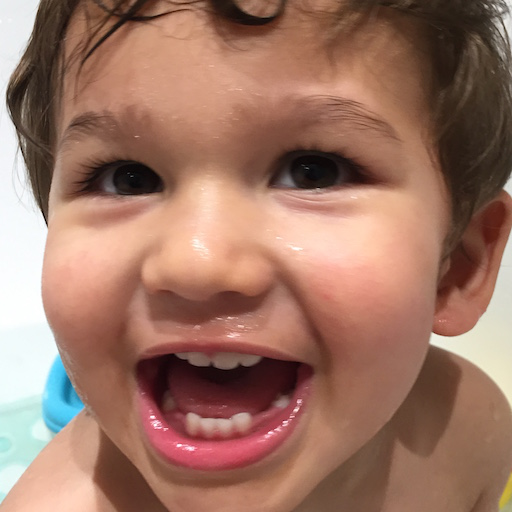

In [23]:
content_image

In [26]:
style_image = Image.open('inputs/style.png')
style_image = style_image.resize((512,512))

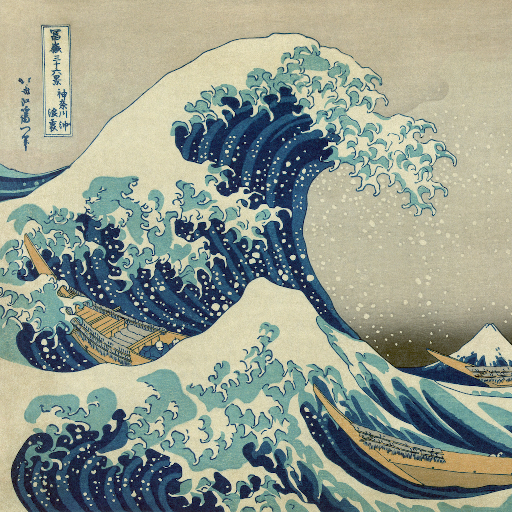

In [28]:
style_image

In [40]:
content_array = np.asarray(content_image,dtype='float32')
content_array = np.expand_dims(content_array, axis=0)

In [43]:
style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)

In [50]:
print(content_array.shape)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [51]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array=content_array[:, :, :, ::-1]

In [52]:
 img = Image.fromarray(np.clip(content_array[0],0,255).astype('uint8') )

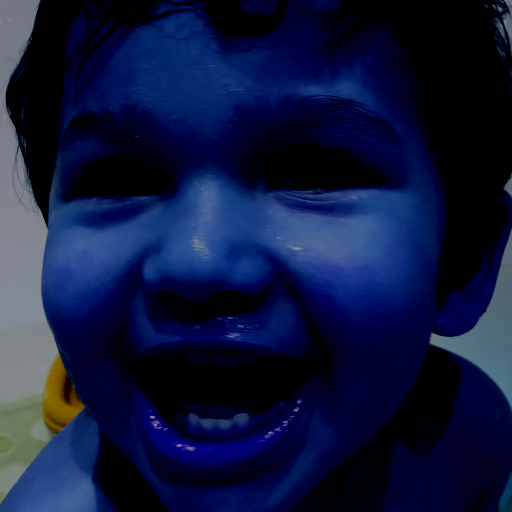

In [54]:
img

In [55]:
style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array=style_array[:, :, :, ::-1]
style_array.shape

(1, 512, 512, 3)

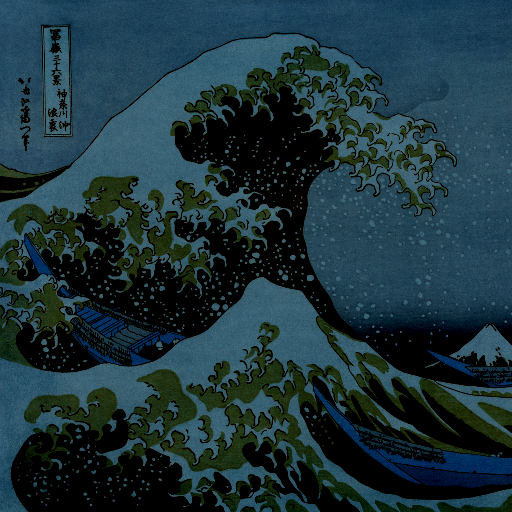

In [59]:
img = Image.fromarray(np.clip(style_array[0],0,255).astype('uint8') )
img

In [61]:
height=512
width=512
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,height,width,3))

In [64]:
combination_image

<tf.Tensor 'Placeholder_1:0' shape=(1, 512, 512, 3) dtype=float32>

In [66]:
input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)

In [68]:
input_tensor

<tf.Tensor 'concat_1:0' shape=(3, 512, 512, 3) dtype=float32>

In [69]:
model = VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 199s 3us/step


In [70]:
model

In [116]:
content_weight = 1.0
style_weight = 1.0
total_variation_weight = 1.0

In [117]:
layers=dict([(layer.name, layer.output) for layer in model.layers])

In [118]:
loss=backend.variable(0.)

<H1>Content Loss</H1>

In [119]:
#content loss of the genrated and content image
def content_loss(content_features, generated_features):
    return backend.sum(backend.square(generated_features - content_features))

In [120]:
layer_features=layers['block2_conv2']
content_image_features=layer_features[0,:,:,:]
combination_features=layer_features[2,:,:,:]
loss+=content_weight*content_loss(content_image_features,combination_features)

<h1>Style Loss</h1>

In [121]:
#gram matrix
def gram_matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram=backend.dot(features, backend.transpose(features))
    return gram

In [122]:
def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height * width
    st=backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st

In [123]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

In [124]:


for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    sl=style_loss(style_features,combination_features)
    loss+=(style_weight/len(feature_layers))*sl



<h1>Variation Loss</h1>

In [125]:
def total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))
loss += total_variation_weight * total_variation_loss(combination_image)

In [126]:
grads = backend.gradients(loss, combination_image)

In [127]:
outputs=[loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)

<h1>Total Loss</h1>

In [128]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [129]:
class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [130]:
evaluator=Evaluator()

In [134]:
x=np.random.uniform(0,255,(1,height,width,3))-128.0

iterations = 1

In [138]:
import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
189853660000.0
Iteration 0 completed in 1008s


In [139]:


print
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')



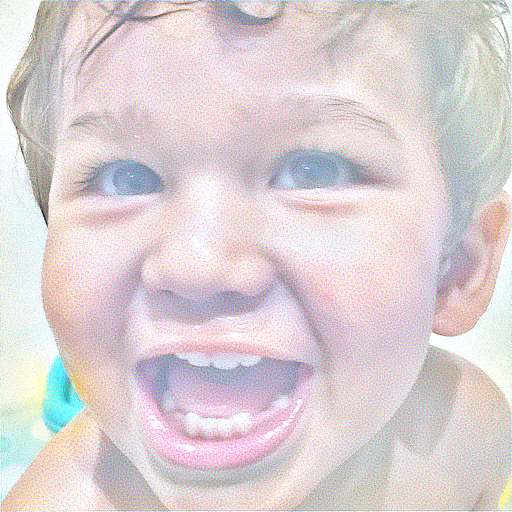

In [140]:
Image.fromarray(x)